# Set up

In [2]:
import pandas as pd
import patsy
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import PredefinedSplit, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.decomposition import PCA
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import scipy.stats

/home/tom/footbot/venv/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
pd.options.display.max_colwidth = 100

# Getting data

In [4]:
file_name = '../csvs/element_gameweek_features_v06.csv'

In [5]:
element_gameweek_df = pd.read_csv(file_name)

In [6]:
current_event = 20

In [7]:
last_train_event = 15

In [8]:
element_gameweek_df =\
element_gameweek_df[
    (element_gameweek_df['event'] <= current_event)
]

In [9]:
element_gameweek_df.fillna(
    element_gameweek_df[element_gameweek_df['event'] <= last_train_event].mean(),
    inplace=True
)

In [10]:
element_gameweek_df = element_gameweek_df[element_gameweek_df['rolling_avg_minutes_element_p3'] >= 60]

# Modelling data

## Splitting data

In [11]:
test_fold = [-1 if i <= last_train_event else 0 for i in element_gameweek_df['event']]
ps = PredefinedSplit(test_fold)

In [12]:
for train_index, test_index in ps.split():
    element_gameweek_df_train, element_gameweek_df_test = \
    element_gameweek_df.copy().iloc[train_index], element_gameweek_df.copy().iloc[test_index]

## Scaling data

In [13]:
scaled_feature_cols = [
    i for i in element_gameweek_df.columns if i not in [
        'safe_web_name', 'element', 'event', 'fixture', 'team',
        'opposition_team', 'element_type', 'was_home', 'is_sunday',
        'is_weekday', 'is_late', 'is_early', 'has_high_points_ever_element',
        'total_points', 'minutes', 'rolling_value_points'
    ]
]

scaled_feature_cols

['value',
 'rolling_avg_total_points_element',
 'rolling_max_total_points_element',
 'rolling_avg_bps_element',
 'rolling_avg_bonus_element',
 'rolling_avg_goals_scored_element',
 'rolling_avg_minutes_element',
 'rolling_avg_clean_sheets_element',
 'rolling_avg_completed_passes_element',
 'rolling_avg_recoveries_element',
 'rolling_avg_assists_element',
 'rolling_avg_key_passes_element',
 'rolling_avg_winning_goals_element',
 'rolling_avg_tackled_element',
 'rolling_avg_dribbles_element',
 'rolling_avg_clearances_blocks_interceptions_element',
 'rolling_avg_big_chances_created_element',
 'rolling_avg_target_missed_element',
 'rolling_avg_fouls_element',
 'rolling_avg_tackles_element',
 'rolling_avg_open_play_crosses_element',
 'rolling_avg_offside_element',
 'rolling_avg_big_chances_missed_element',
 'rolling_avg_saves_element',
 'rolling_avg_goals_conceded_element',
 'rolling_avg_attempted_passes_element',
 'rolling_avg_errors_leading_to_goal_element',
 'rolling_avg_errors_leading_to_

In [14]:
scaled_df_train = element_gameweek_df_train.copy()
scaled_df_test = element_gameweek_df_test.copy()
scaled_df = element_gameweek_df.copy()

scaler = StandardScaler().fit(scaled_df_train[scaled_feature_cols].values)

scaled_df_train = scaler.transform(scaled_df_train[scaled_feature_cols].values)
scaled_df_test = scaler.transform(scaled_df_test[scaled_feature_cols].values)
scaled_df = scaler.transform(scaled_df[scaled_feature_cols].values)

element_gameweek_df_train[scaled_feature_cols] = scaled_df_train
element_gameweek_df_test[scaled_feature_cols] = scaled_df_test
element_gameweek_df[scaled_feature_cols] = scaled_df

## Building model

In [15]:
formula = \
'total_points ~ C(element_type) + C(team) + C(opposition_team) + ' + \
' + '.join([i for i in element_gameweek_df.columns if i not in
 [
     'safe_web_name',
     'element',
     'event',
     'fixture',
     'team',
     'opposition_team',
     'element_type',
     'minutes',
     'rolling_value_points',
     'total_points',
     
     'expected_total_points_against_opposition_team',
     'rolling_avg_total_points_element_home',
     'rolling_max_total_points_element',
     'rolling_avg_bps_element',
     'expected_total_points_element_home_away',
     'rolling_avg_total_points_element_away',
     'rolling_avg_total_points_own_team',
     'rolling_avg_total_points_against_opposition_team',
     'rolling_avg_minutes_element',
     'rolling_avg_total_points_opposition_team',
     'rolling_avg_dribbles_element',
     'rolling_avg_total_points_against_opposition_team_element_type',
     'rolling_avg_total_points_against_opposition_team_element_type_away',
     'rolling_avg_total_points_against_opposition_team_element_type_home',
     'rolling_avg_goals_conceded_element',
     'rolling_avg_completed_passes_element',
     'rolling_avg_total_points_element_type',
     'rolling_avg_recoveries_element',
     
 ]])

In [16]:
print(formula)

total_points ~ C(element_type) + C(team) + C(opposition_team) + was_home + is_sunday + is_weekday + is_early + is_late + value + rolling_avg_total_points_element + has_high_points_ever_element + rolling_avg_bonus_element + rolling_avg_goals_scored_element + rolling_avg_clean_sheets_element + rolling_avg_assists_element + rolling_avg_key_passes_element + rolling_avg_winning_goals_element + rolling_avg_tackled_element + rolling_avg_clearances_blocks_interceptions_element + rolling_avg_big_chances_created_element + rolling_avg_target_missed_element + rolling_avg_fouls_element + rolling_avg_tackles_element + rolling_avg_open_play_crosses_element + rolling_avg_offside_element + rolling_avg_big_chances_missed_element + rolling_avg_saves_element + rolling_avg_attempted_passes_element + rolling_avg_errors_leading_to_goal_element + rolling_avg_errors_leading_to_goal_attempt_element + rolling_avg_own_goals_element + rolling_avg_penalties_concededd_element + rolling_avg_penalties_missed_element +

In [17]:
y, X = patsy.dmatrices(formula, element_gameweek_df, return_type='matrix')

In [18]:
for train_index, test_index in ps.split():
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

## Principal components

In [19]:
pc_index = X.design_info.column_names.index('value')

In [20]:
pca = PCA()
pca.fit(X_train[:,pc_index:])

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

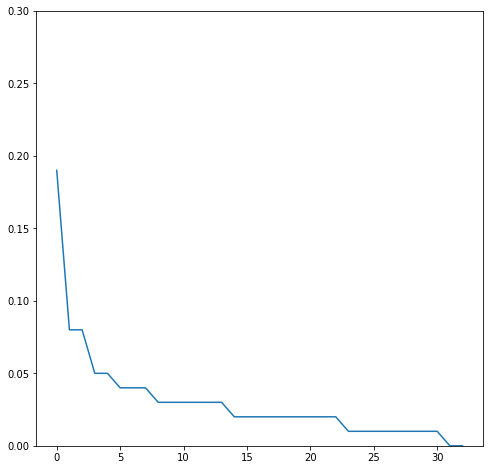

In [21]:
plt.figure(figsize=(8, 8))
plt.plot(pca.explained_variance_ratio_.round(2))
plt.ylim(0, 0.3)
plt.show()

In [22]:
X_train_pca = np.concatenate((X_train[:,:pc_index], pca.transform(X_train[:,pc_index:])), axis=1)
X_train_pca.shape

(2696, 80)

In [23]:
X_test_pca = np.concatenate((X_test[:,:pc_index], pca.transform(X_test[:,pc_index:])), axis=1)
X_test_pca.shape

(948, 80)

In [24]:
X_pca = np.concatenate((X[:,:pc_index], pca.transform(X[:,pc_index:])), axis=1)
X_pca.shape

(3644, 80)

## Selecting features

### Linear regression

In [24]:
lr_estimator = LinearRegression()
lr_selector = RFECV(lr_estimator, step=1,
                 scoring='neg_mean_squared_error',
                 cv=ps, n_jobs=1, verbose=1)
lr_selector.fit(X, y.ravel())

Fitting estimator with 80 features.
Fitting estimator with 79 features.
Fitting estimator with 78 features.
Fitting estimator with 77 features.
Fitting estimator with 76 features.
Fitting estimator with 75 features.
Fitting estimator with 74 features.
Fitting estimator with 73 features.
Fitting estimator with 72 features.
Fitting estimator with 71 features.
Fitting estimator with 70 features.
Fitting estimator with 69 features.
Fitting estimator with 68 features.
Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 fe

RFECV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
      estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                 normalize=False),
      min_features_to_select=1, n_jobs=1, scoring='neg_mean_squared_error',
      step=1, verbose=1)

In [25]:
sum(lr_selector.support_)

43

In [26]:
lr_selector.support_

array([False,  True,  True,  True,  True, False, False, False,  True,
        True,  True,  True,  True, False,  True, False,  True, False,
        True,  True, False, False,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True, False,  True,
        True,  True,  True, False, False, False, False, False, False,
        True,  True, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False,  True, False,
       False, False, False,  True,  True,  True, False, False])

In [27]:
lr_X_sel = X[:,lr_selector.support_]
lr_X_train_sel = X_train[:,lr_selector.support_]
lr_X_test_sel = X_test[:,lr_selector.support_]

### Ridge regression

In [25]:
ridge_estimator = Ridge(alpha=483)
ridge_selector = RFECV(ridge_estimator, step=1,
                 scoring='neg_mean_squared_error',
                 cv=ps, n_jobs=1, verbose=1)
ridge_selector.fit(
    X,
    y.ravel()
)

Fitting estimator with 80 features.
Fitting estimator with 79 features.
Fitting estimator with 78 features.
Fitting estimator with 77 features.
Fitting estimator with 76 features.
Fitting estimator with 75 features.
Fitting estimator with 74 features.
Fitting estimator with 73 features.
Fitting estimator with 72 features.
Fitting estimator with 71 features.
Fitting estimator with 70 features.
Fitting estimator with 69 features.
Fitting estimator with 68 features.
Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 fe

RFECV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
      estimator=Ridge(alpha=483, copy_X=True, fit_intercept=True, max_iter=None,
                      normalize=False, random_state=None, solver='auto',
                      tol=0.001),
      min_features_to_select=1, n_jobs=1, scoring='neg_mean_squared_error',
      step=1, verbose=1)

In [26]:
sum(ridge_selector.support_)

10

In [30]:
ridge_selector.support_

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False,  True,  True, False, False, False, False, False, False,
       False, False, False,  True, False,  True, False,  True])

In [31]:
ridge_X_sel = X[:,ridge_selector.support_]
ridge_X_train_sel = X_train[:,ridge_selector.support_]
ridge_X_test_sel = X_test[:,ridge_selector.support_]

### Lasso regression

In [32]:
lasso_estimator = Lasso(
    alpha=0.0271
    
)
lasso_selector = RFECV(lasso_estimator, step=1,
                 scoring='neg_mean_squared_error',
                 cv=ps, n_jobs=1, verbose=1)
lasso_selector.fit(
    X,
    y.ravel())

Fitting estimator with 80 features.
Fitting estimator with 79 features.
Fitting estimator with 78 features.
Fitting estimator with 77 features.
Fitting estimator with 76 features.
Fitting estimator with 75 features.
Fitting estimator with 74 features.
Fitting estimator with 73 features.
Fitting estimator with 72 features.
Fitting estimator with 71 features.
Fitting estimator with 70 features.
Fitting estimator with 69 features.
Fitting estimator with 68 features.
Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 fe

RFECV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
      estimator=Lasso(alpha=0.0271, copy_X=True, fit_intercept=True,
                      max_iter=1000, normalize=False, positive=False,
                      precompute=False, random_state=None, selection='cyclic',
                      tol=0.0001, warm_start=False),
      min_features_to_select=1, n_jobs=1, scoring='neg_mean_squared_error',
      step=1, verbose=1)

In [33]:
sum(lasso_selector.support_)

12

In [34]:
lasso_selector.support_

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False,  True,  True, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False,  True,  True, False, False, False, False,  True, False,
       False, False, False,  True, False,  True,  True,  True])

In [35]:
lasso_X_sel = X[:,lasso_selector.support_]
lasso_X_train_sel = X_train[:,lasso_selector.support_]
lasso_X_test_sel = X_test[:,lasso_selector.support_]

### Principal component regression

In [36]:
pc_estimator = Lasso(alpha=0.025)

pc_selector = RFECV(pc_estimator, step=1,
                 scoring='neg_mean_squared_error',
                 cv=ps, n_jobs=1, verbose=1)
pc_selector.fit(
    X_pca,
    y.ravel())

Fitting estimator with 80 features.
Fitting estimator with 79 features.
Fitting estimator with 78 features.
Fitting estimator with 77 features.
Fitting estimator with 76 features.
Fitting estimator with 75 features.
Fitting estimator with 74 features.
Fitting estimator with 73 features.
Fitting estimator with 72 features.
Fitting estimator with 71 features.
Fitting estimator with 70 features.
Fitting estimator with 69 features.
Fitting estimator with 68 features.
Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 fe

RFECV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
      estimator=Lasso(alpha=0.025, copy_X=True, fit_intercept=True,
                      max_iter=1000, normalize=False, positive=False,
                      precompute=False, random_state=None, selection='cyclic',
                      tol=0.0001, warm_start=False),
      min_features_to_select=1, n_jobs=1, scoring='neg_mean_squared_error',
      step=1, verbose=1)

In [37]:
sum(pc_selector.support_)

24

In [38]:
pc_selector.support_

array([False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False,  True, False, False,
       False, False, False, False, False, False,  True, False, False,
       False,  True,  True,  True,  True,  True,  True,  True, False,
       False, False,  True,  True, False, False,  True,  True,  True,
        True,  True, False,  True, False, False, False, False, False,
        True, False,  True,  True,  True, False, False, False])

In [39]:
pc_X_sel = X_pca[:,pc_selector.support_]
pc_X_train_sel = X_train_pca[:,pc_selector.support_]
pc_X_test_sel = X_test_pca[:,pc_selector.support_]

## Tuning model

### GP tuner

#### Ridge regression

In [91]:
ridge_space  = [Real(10**-8, 10**3, 'log-uniform', name='alpha')]

In [92]:
ridge_gp_model = Ridge()

@use_named_args(ridge_space)
def ridge_objective(**params):
    ridge_gp_model.set_params(**params)

    return -np.mean(
        cross_val_score(
            ridge_gp_model,
            X,
#             ridge_X_sel,
            y.ravel(),
            cv=ps,
            n_jobs=1,
            scoring="neg_mean_squared_error"))

In [93]:
ridge_res_gp_arr = []
for i in range(1, 2):
    print('minimisation iteration', i)
    ridge_res_gp = gp_minimize(ridge_objective, ridge_space, n_calls=50, verbose=2)
    ridge_res_gp_arr.append(ridge_res_gp)

minimisation iteration 1
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0668
Function value obtained: 9.6148
Current minimum: 9.6148
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0271
Function value obtained: 9.6159
Current minimum: 9.6148
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0172
Function value obtained: 9.6161
Current minimum: 9.6148
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0188
Function value obtained: 9.6161
Current minimum: 9.6148
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.0166
Function value obtained: 9.5942
Current minimum: 9.5942
Iteration 

Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 0.9319
Function value obtained: 9.3653
Current minimum: 9.3653
Iteration No: 42 started. Searching for the next optimal point.
Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 0.8000
Function value obtained: 9.3762
Current minimum: 9.3653
Iteration No: 43 started. Searching for the next optimal point.
Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 1.0035
Function value obtained: 9.3653
Current minimum: 9.3653
Iteration No: 44 started. Searching for the next optimal point.
Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 0.9351
Function value obtained: 9.3653
Current minimum: 9.3653
Iteration No: 45 started. Searching for the next optimal point.
Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 0.8895
Function value obtained: 9.3653
Current minimum: 9.3653
Iteration No: 46 started. Sea

In [94]:
# Full features (without elements)
for i in ridge_res_gp_arr:
    print(i.fun)
print('\n')
for i in ridge_res_gp_arr:
    print(i.x)

9.365319150866409


[487.09903214469045]


In [ ]:
# selected features (without elements)
for i in ridge_res_gp_arr:
    print(i.fun)
print('\n')
for i in ridge_res_gp_arr:
    print(i.x)

#### Lasso regression

In [95]:
lasso_space  = [Real(10**-8, 10**1, 'log-uniform', name='alpha')]

In [96]:
lasso_gp_model = Lasso()

@use_named_args(lasso_space)
def lasso_objective(**params):
    lasso_gp_model.set_params(**params)

    return -np.mean(
        cross_val_score(
            lasso_gp_model,
            X,
#             lasso_X_sel,
            y.ravel(),
            cv=ps,
            n_jobs=1,
            scoring="neg_mean_squared_error"))

In [97]:
lasso_res_gp_arr = []
for i in range(1, 2):
    print('minimisation iteration', i)
    lasso_res_gp = gp_minimize(lasso_objective, lasso_space, n_calls=50, verbose=2)
    lasso_res_gp_arr.append(lasso_res_gp)

minimisation iteration 1
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0580
Function value obtained: 9.5852
Current minimum: 9.5852
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0235
Function value obtained: 10.3133
Current minimum: 9.5852
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0127
Function value obtained: 10.4092
Current minimum: 9.5852
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.2870
Function value obtained: 9.6161
Current minimum: 9.5852
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.2903
Function value obtained: 9.6161
Current minimum: 9.5852
Iteratio

Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 0.8623
Function value obtained: 9.2914
Current minimum: 9.2914
Iteration No: 42 started. Searching for the next optimal point.
Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 0.7993
Function value obtained: 9.2914
Current minimum: 9.2914
Iteration No: 43 started. Searching for the next optimal point.
Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 0.8638
Function value obtained: 9.2922
Current minimum: 9.2914
Iteration No: 44 started. Searching for the next optimal point.
Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 0.8597
Function value obtained: 9.2914
Current minimum: 9.2914
Iteration No: 45 started. Searching for the next optimal point.
Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 0.7976
Function value obtained: 9.2914
Current minimum: 9.2914
Iteration No: 46 started. Sea

In [98]:
# Full features (without elements)
for i in lasso_res_gp_arr:
    print(i.fun)
print('\n')
for i in lasso_res_gp_arr:
    print(i.x)

9.29133494973959


[0.027510027951916257]


In [100]:
2*len(X) * 0.027510027951916257

200.49308371356568

In [101]:
1/200

0.005

In [ ]:
# Selected features (without elements)
for i in lasso_res_gp_arr:
    print(i.fun)
print('\n')
for i in lasso_res_gp_arr:
    print(i.x)

# Evaluating model

## Linear regression

In [40]:
lr_model = LinearRegression()
lr_model.fit(lr_X_train_sel, y_train.ravel())

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [41]:
# get predictions for test set
lr_y_pred = lr_model.predict(lr_X_test_sel).flatten()

# calculate cross entropy loss for test set
lr_test_loss = (
    mean_absolute_error(y_test, lr_y_pred),
    mean_squared_error(y_test, lr_y_pred),
    r2_score(y_test, lr_y_pred)
)
lr_test_loss

(2.1838135333614184, 9.398113195086708, 0.09692759648523164)

In [42]:
# refit lr_model on all data
lr_model_full = LinearRegression()
lr_model_full.fit(lr_X_sel, y.ravel())

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [43]:
# get predictions for whole set
lr_y_pred_full = lr_model_full.predict(lr_X_sel).flatten()

# calculate cross entropy loss for test set
lr_test_loss_full = (
    mean_absolute_error(y, lr_y_pred_full),
    mean_squared_error(y, lr_y_pred_full),
    r2_score(y, lr_y_pred_full)
)
lr_test_loss_full

(2.0883410152574604, 8.260660947309697, 0.13668687587463468)

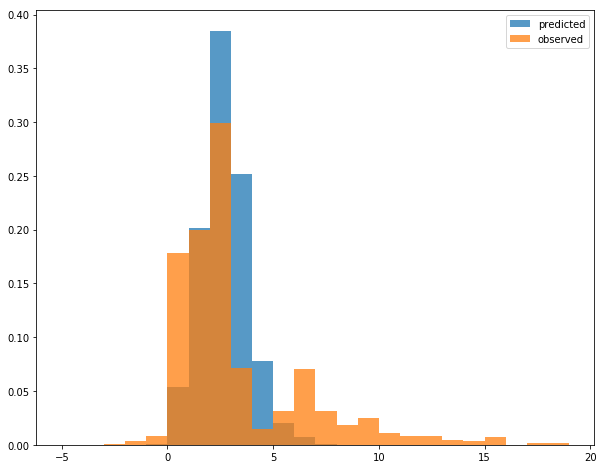

In [44]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(lr_y_pred), bins=range(-5,20), alpha=0.75, density=True, label='predicted')
plt.hist(pd.Series(y_test.ravel()), bins=range(-5,20), alpha=0.75, density=True, label='observed')
plt.legend()
plt.show()

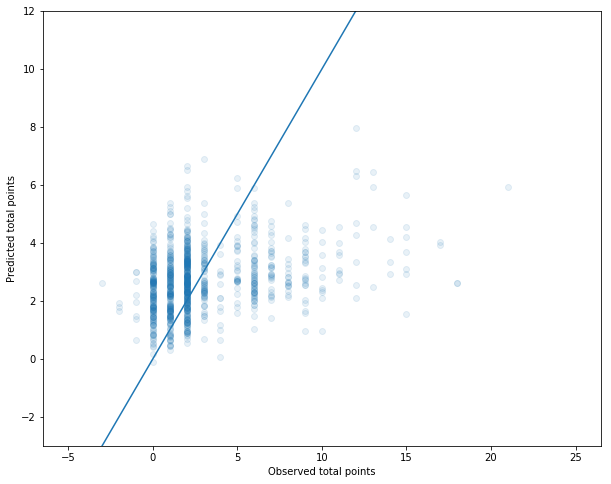

In [45]:
plt.figure(figsize=(10, 8))
plt.scatter(pd.Series(y_test.ravel()), pd.Series(lr_y_pred), alpha=0.1)
plt.plot(np.linspace(-5, 25), np.linspace(-5, 25))
plt.ylabel('Predicted total points')
plt.xlabel('Observed total points')
plt.ylim((-3, 12))
plt.show()

#### Model analysis

In [46]:
lr_cols = np.array(X.design_info.column_names)[lr_selector.support_]

In [47]:
lr_weight_df = pd.DataFrame(
    list(zip(lr_cols,
             lr_model.coef_.round(3), )),
             columns=['feature', 'weight'])

In [48]:
lr_weight_df.sort_values('weight', ascending=False)

,feature,weight
18,C(opposition_team)[T.7],1.869
20,C(opposition_team)[T.9],1.774
27,C(opposition_team)[T.16],1.732
16,C(opposition_team)[T.4],1.662
26,C(opposition_team)[T.15],1.614
17,C(opposition_team)[T.5],1.476
21,C(opposition_team)[T.10],1.369
30,C(opposition_team)[T.20],1.032
28,C(opposition_team)[T.18],0.982
25,C(opposition_team)[T.14],0.977


Teams:  
12 - Liverpool  
9 - Fulham

In [49]:
lr_df = pd.DataFrame(lr_X_sel, columns=lr_cols)
lr_df['predicted_total_points'] = lr_y_pred_full
lr_df['total_points'] = y
lr_df['residual'] = lr_df['total_points'] - lr_df['predicted_total_points']
lr_df[['total_points', 'predicted_total_points', 'residual']].head()

,total_points,predicted_total_points,residual
0,3.0,2.915379,0.084621
1,3.0,3.509453,-0.509453
2,1.0,3.296052,-2.296052
3,2.0,3.804489,-1.804489
4,11.0,3.280844,7.719156


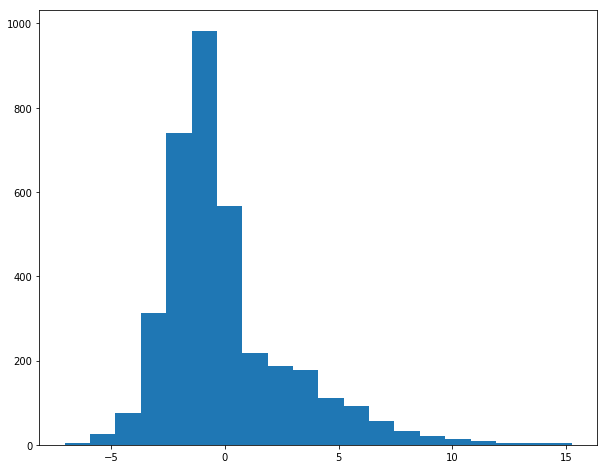

In [50]:
plt.figure(figsize=(10, 8))
plt.hist(lr_df['residual'], bins=20)
plt.show()

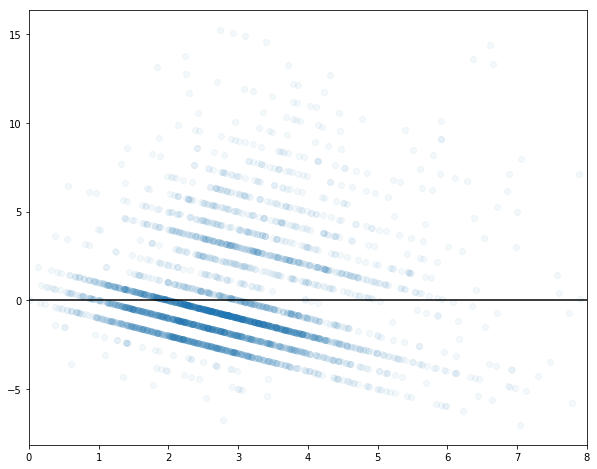

In [51]:
plt.figure(figsize=(10, 8))
plt.scatter(lr_df['predicted_total_points'], lr_df['residual'], alpha=0.05)
plt.plot(np.linspace(0, 8, 100), np.zeros(100), color='black')
plt.xlim(0, 8)
plt.show()

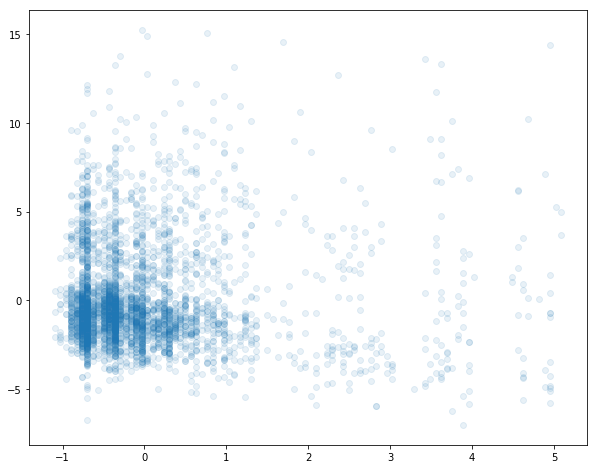

In [52]:
plt.figure(figsize=(10, 8))
plt.scatter(lr_df['value'], lr_df['residual'], alpha=0.1)
plt.show()

## Ridge regression

In [32]:
ridge_model = Ridge(alpha=1e-8)
ridge_model.fit(ridge_X_train_sel, y_train.ravel())

Ridge(alpha=1e-08, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [33]:
# get predictions for test set
ridge_y_pred = ridge_model.predict(ridge_X_test_sel).flatten()

# calculate cross entropy loss for test set
ridge_test_loss = (
    mean_absolute_error(y_test, ridge_y_pred),
    mean_squared_error(y_test, ridge_y_pred),
    r2_score(y_test, ridge_y_pred)
)

ridge_test_loss

(2.1275099791055783, 9.06864865345836, 0.12858611445634427)

In [34]:
# refit ridge_model on all data
ridge_model_full = Ridge(alpha=1e-8)
ridge_model_full.fit(ridge_X_sel, y.ravel())

Ridge(alpha=1e-08, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [35]:
# get predictions for whole set
ridge_y_pred_full = ridge_model_full.predict(ridge_X_sel).flatten()

# calculate cross entropy loss for test set
ridge_test_loss_full = (
    mean_absolute_error(y, ridge_y_pred_full),
    mean_squared_error(y, ridge_y_pred_full),
    r2_score(y, ridge_y_pred_full))
ridge_test_loss_full

(2.1260085514816294, 8.509186581726475, 0.11071371909673022)

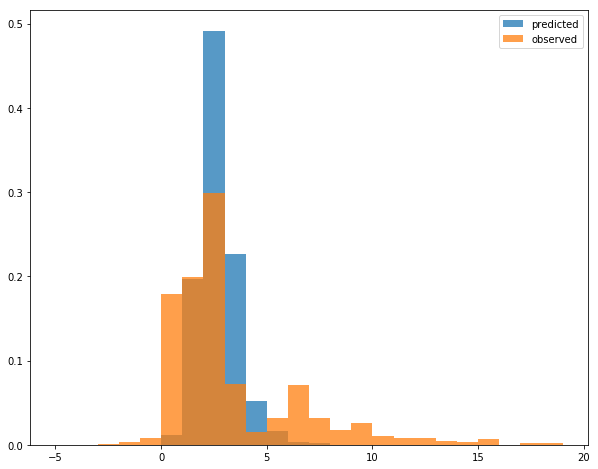

In [36]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(ridge_y_pred), bins=range(-5,20), alpha=0.75, density=True, label='predicted')
plt.hist(pd.Series(y_test.ravel()), bins=range(-5,20), alpha=0.75, density=True, label='observed')
plt.legend()
plt.show()

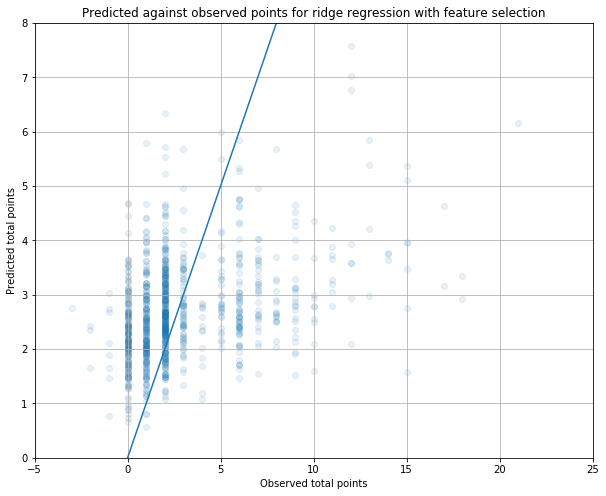

In [37]:
plt.figure(figsize=(10, 8))
plt.scatter(pd.Series(y_test.ravel()), pd.Series(ridge_y_pred), alpha=0.1)
plt.plot(np.linspace(-5, 25), np.linspace(-5, 25))
plt.ylabel('Predicted total points')
plt.xlabel('Observed total points')
plt.ylim((0, 8))
plt.xlim((-5, 25))
plt.title('Predicted against observed points for ridge regression with feature selection')
plt.grid()
plt.show()

#### Model analysis

In [109]:
ridge_cols = np.array(X.design_info.column_names)[ridge_selector.support_]

In [110]:
ridge_weight_df = pd.DataFrame(
    list(zip(ridge_cols,
             ridge_model.coef_.round(3), )),
             columns=['feature', 'weight'])

In [111]:
ridge_weight_df.sort_values('weight', ascending=False)

,feature,weight
0,C(team)[T.12],0.758
1,C(opposition_team)[T.9],0.714
3,value,0.499
7,rolling_avg_minutes_element_p3,0.269
6,rolling_avg_saves_element,0.247
5,rolling_avg_big_chances_missed_element,0.201
9,expected_total_points_against_opposition_team_home_away,0.156
4,rolling_avg_key_passes_element,0.139
8,rolling_avg_goals_scored_opposition_team,-0.303
2,C(opposition_team)[T.12],-0.494


Teams:  
12 - Liverpool  
9 - Fulham

In [62]:
ridge_df = pd.DataFrame(ridge_X_sel, columns=ridge_cols)
ridge_df['predicted_total_points'] = ridge_y_pred_full
ridge_df['total_points'] = y
ridge_df['residual'] = ridge_df['total_points'] - ridge_df['predicted_total_points']
ridge_df[['total_points', 'predicted_total_points', 'residual']].head()

,total_points,predicted_total_points,residual
0,3.0,3.332893,-0.332893
1,3.0,4.836041,-1.836041
2,1.0,4.749697,-3.749697
3,2.0,3.886573,-1.886573
4,11.0,3.333038,7.666962


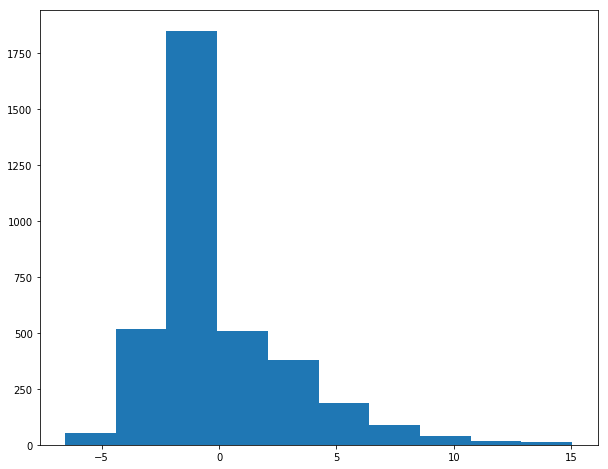

In [63]:
plt.figure(figsize=(10, 8))
plt.hist(ridge_df['residual'] )
plt.show()

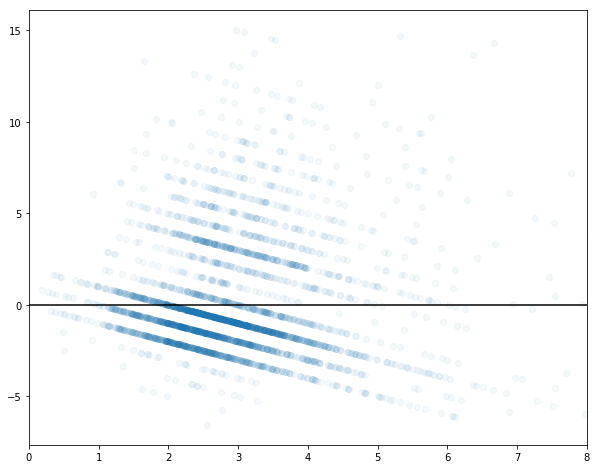

In [64]:
plt.figure(figsize=(10, 8))
plt.scatter(ridge_df['predicted_total_points'], ridge_df['residual'], alpha=0.05)
plt.plot(np.linspace(0, 8, 100), np.zeros(100), color='black')
plt.xlim(0, 8)
plt.show()

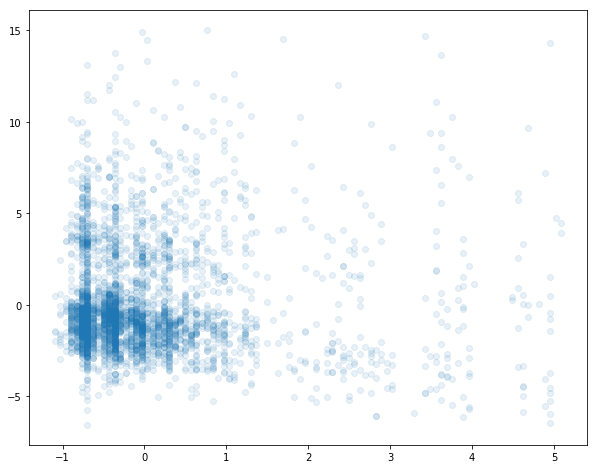

In [65]:
plt.figure(figsize=(10, 8))
plt.scatter(ridge_df['value'], ridge_df['residual'], alpha=0.1)
plt.show()

## Lasso regression

In [66]:
lasso_model = Lasso(alpha=10**-8)
lasso_model.fit(lasso_X_train_sel, y_train.ravel())

Lasso(alpha=1e-08, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [67]:
# get predictions for test set
lasso_y_pred = lasso_model.predict(lasso_X_test_sel).flatten()

# calculate cross entropy loss for test set
lasso_test_loss = (
    mean_absolute_error(y_test, lasso_y_pred),
    mean_squared_error(y_test, lasso_y_pred),
    r2_score(y_test, lasso_y_pred)
)

lasso_test_loss

(2.137366202073004, 9.172222338423397, 0.11863363413602235)

In [68]:
# refit lasso_model on all data
lasso_model_full = Lasso(alpha=1e-5)
lasso_model_full.fit(lasso_X_sel, y.ravel())

Lasso(alpha=1e-05, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [69]:
# get predictions for whole set
lasso_y_pred_full = lasso_model_full.predict(lasso_X_sel).flatten()

# calculate cross entropy loss for test set
lasso_test_loss_full = (
    mean_absolute_error(y, lasso_y_pred_full),
    mean_squared_error(y, lasso_y_pred_full),
    r2_score(y, lasso_y_pred_full))
lasso_test_loss_full

(2.116446299120702, 8.499178050145952, 0.1117597003713281)

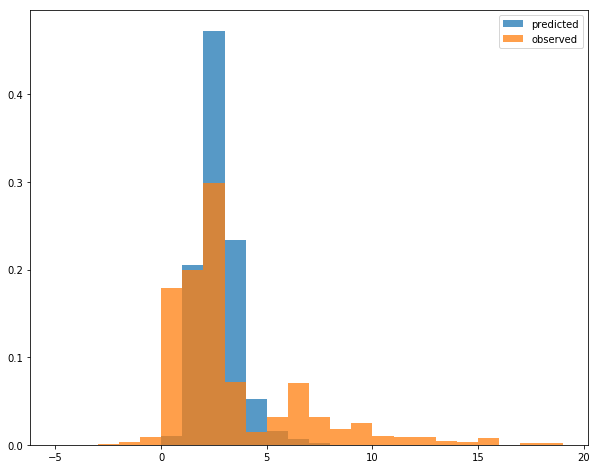

In [70]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(lasso_y_pred), bins=range(-5,20), alpha=0.75, density=True, label='predicted')
plt.hist(pd.Series(y_test.ravel()), bins=range(-5,20), alpha=0.75, density=True, label='observed')
plt.legend()
plt.show()

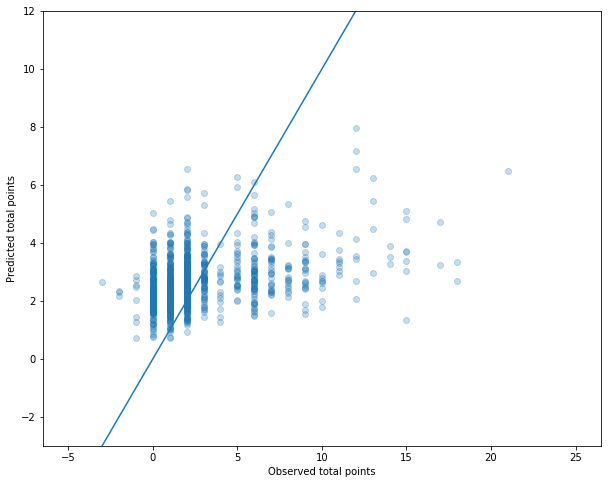

In [71]:
plt.figure(figsize=(10, 8))
plt.scatter(pd.Series(y_test.ravel()), pd.Series(lasso_y_pred), alpha=0.25)
plt.plot(np.linspace(-5, 25), np.linspace(-5, 25))
plt.ylabel('Predicted total points')
plt.xlabel('Observed total points')
plt.ylim((-3, 12))
plt.show()

#### Model analysis

In [72]:
lasso_cols = np.array(X.design_info.column_names)[lasso_selector.support_]

In [73]:
lasso_weight_df = pd.DataFrame(
    list(zip(lasso_cols,
             lasso_model.coef_.round(3), )),
             columns=['feature', 'weight'])

In [74]:
lasso_weight_df.sort_values('weight', ascending=False)

,feature,weight
0,C(team)[T.12],0.905
3,value,0.531
6,rolling_avg_saves_element,0.263
8,rolling_avg_minutes_element_p3,0.262
1,was_home,0.254
5,rolling_avg_big_chances_missed_element,0.190
10,rolling_avg_goals_conceded_opposition_team,0.170
7,rolling_avg_penalties_concededd_element,0.161
4,rolling_avg_key_passes_element,0.151
11,expected_total_points_against_opposition_team_home_away,0.134


Teams:  
12 - Liverpool  

In [75]:
lasso_df = pd.DataFrame(lasso_X_sel, columns=lasso_cols)
lasso_df['predicted_total_points'] = lasso_y_pred_full
lasso_df['total_points'] = y
lasso_df['residual'] = lasso_df['total_points'] - lasso_df['predicted_total_points']
lasso_df[['total_points', 'predicted_total_points', 'residual']].head()

,total_points,predicted_total_points,residual
0,3.0,2.788573,0.211427
1,3.0,5.482729,-2.482729
2,1.0,4.423077,-3.423077
3,2.0,3.887173,-1.887173
4,11.0,3.400327,7.599673


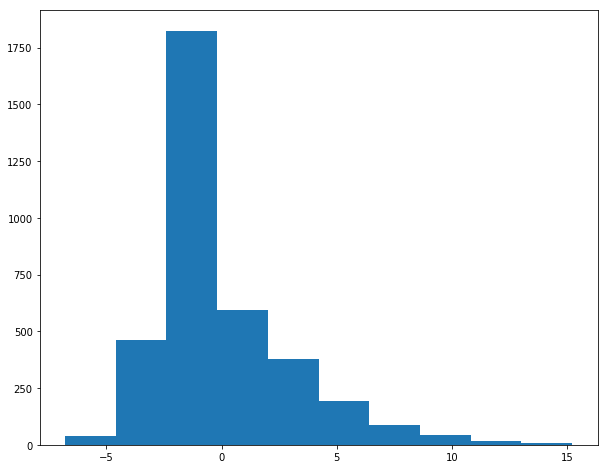

In [76]:
plt.figure(figsize=(10, 8))
plt.hist(lasso_df['residual'] )
plt.show()

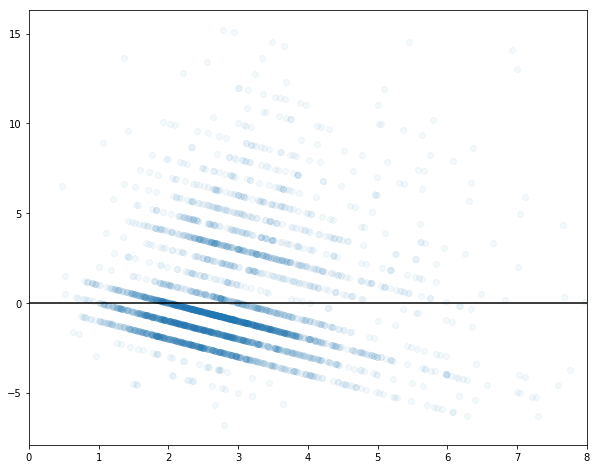

In [77]:
plt.figure(figsize=(10, 8))
plt.scatter(lasso_df['predicted_total_points'], lasso_df['residual'], alpha=0.05)
plt.plot(np.linspace(0, 8, 100), np.zeros(100), color='black')
plt.xlim(0, 8)
plt.show()

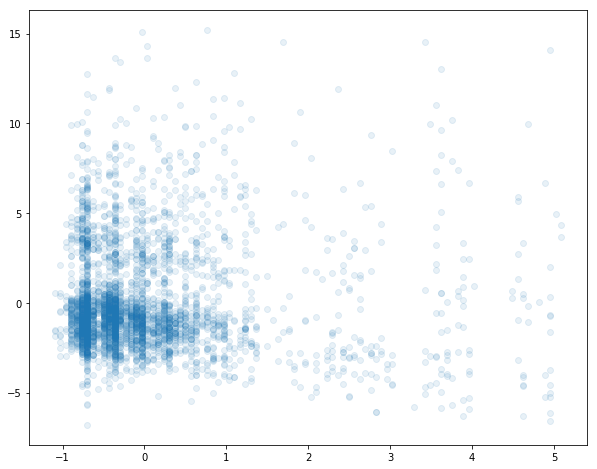

In [78]:
plt.figure(figsize=(10, 8))
plt.scatter(lasso_df['value'], lasso_df['residual'], alpha=0.1)
plt.show()

## Principal component regression

In [79]:
pc_model = LinearRegression()
pc_model.fit(pc_X_train_sel, y_train.ravel())

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [80]:
# get predictions for test set
pc_y_pred = pc_model.predict(pc_X_test_sel).flatten()

# calculate cross entropy loss for test set
pc_test_loss = (
    mean_absolute_error(y_test, pc_y_pred),
    mean_squared_error(y_test, pc_y_pred),
    r2_score(y_test, pc_y_pred)
)

pc_test_loss

(2.143222395268621, 9.122254825987177, 0.12343505338015559)

In [81]:
# refit pc_model on all data
pc_model_full = LinearRegression()
pc_model_full.fit(pc_X_sel, y.ravel())

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [82]:
# get predictions for whole set
pc_y_pred_full = pc_model_full.predict(pc_X_sel).flatten()

# calculate cross entropy loss for test set
pc_test_loss_full = (
    mean_absolute_error(y, pc_y_pred_full),
    mean_squared_error(y, pc_y_pred_full),
    r2_score(y, pc_y_pred_full))
pc_test_loss_full

(2.1148552090373176, 8.423655011883705, 0.11965253491828476)

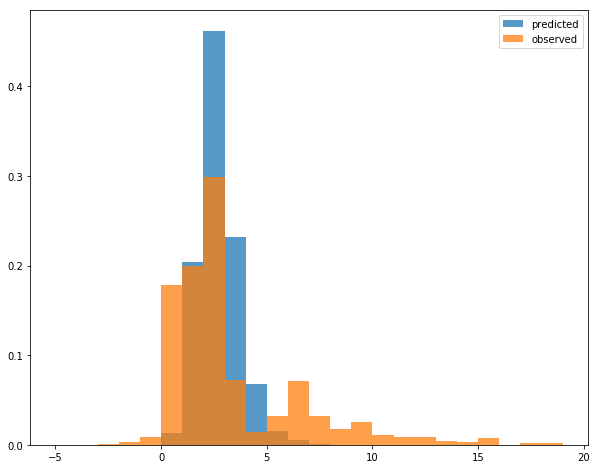

In [83]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(pc_y_pred), bins=range(-5,20), alpha=0.75, density=True, label='predicted')
plt.hist(pd.Series(y_test.ravel()), bins=range(-5,20), alpha=0.75, density=True, label='observed')
plt.legend()
plt.show()

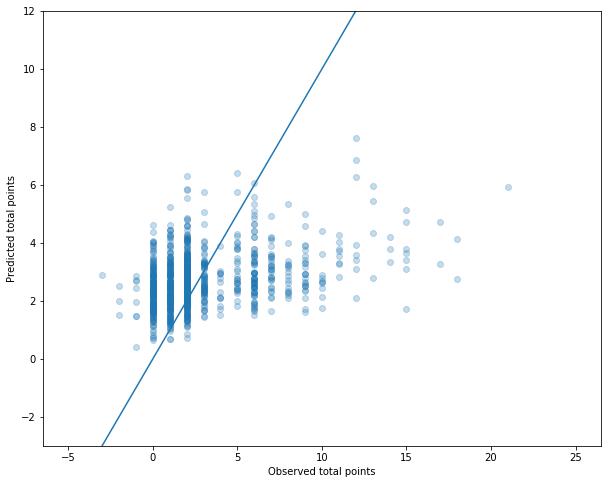

In [84]:
plt.figure(figsize=(10, 8))
plt.scatter(pd.Series(y_test.ravel()), pd.Series(pc_y_pred), alpha=0.25)
plt.plot(np.linspace(-5, 25), np.linspace(-5, 25))
plt.ylabel('Predicted total points')
plt.xlabel('Observed total points')
plt.ylim((-3, 12))
plt.show()

#### Model analysis

In [86]:
pc_df = pd.DataFrame(pc_X_sel)
pc_df['predicted_total_points'] = pc_y_pred_full
pc_df['total_points'] = y
pc_df['residual'] = pc_df['total_points'] - pc_df['predicted_total_points']
pc_df[['total_points', 'predicted_total_points', 'residual']].head()

,total_points,predicted_total_points,residual
0,3.0,3.004312,-0.004312
1,3.0,5.133436,-2.133436
2,1.0,4.361720,-3.361720
3,2.0,3.634210,-1.634210
4,11.0,3.240191,7.759809


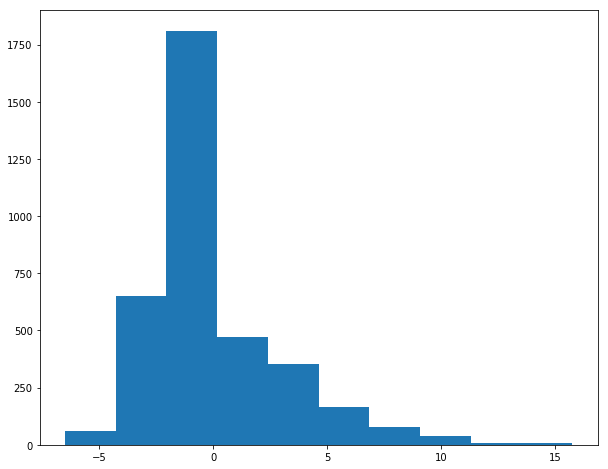

In [87]:
plt.figure(figsize=(10, 8))
plt.hist(pc_df['residual'] )
plt.show()

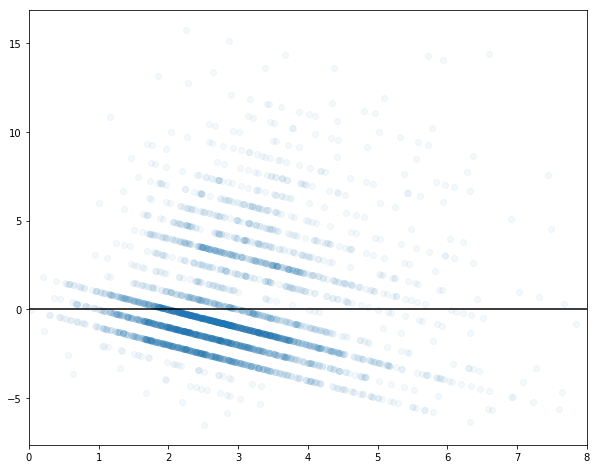

In [88]:
plt.figure(figsize=(10, 8))
plt.scatter(pc_df['predicted_total_points'], pc_df['residual'], alpha=0.05)
plt.plot(np.linspace(0, 8, 100), np.zeros(100), color='black')
plt.xlim(0, 8)
plt.show()

## Summary

In [90]:
pd.DataFrame([
    ('Linear regression', lr_test_loss[0], lr_test_loss[1], lr_test_loss[2]),
    ('Ridge regression', ridge_test_loss[0], ridge_test_loss[1], ridge_test_loss[2]),
    ('Lasso regression', lasso_test_loss[0], lasso_test_loss[1], lasso_test_loss[2]),
    ('Principal component regression', pc_test_loss[0], pc_test_loss[1], pc_test_loss[2]),
], columns=['model', 'MAE', 'MSE', 'r2'])

,model,MAE,MSE,r2
0,Linear regression,2.183814,9.398113,0.096928
1,Ridge regression,2.127510,9.068649,0.128586
2,Lasso regression,2.137366,9.172222,0.118634
3,Principal component regression,2.143222,9.122255,0.123435
